<a href="https://colab.research.google.com/github/jibook/git-remote/blob/master/TensorFlow_10_Filter_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv3_block4_out"
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
def compute_loss(input_image, filter_index):
  activation = feature_extractor(input_image)
  # We avoid border artifacts by only involving non-border pixels in the loss.
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img, filter_index)
  # Compute gradients.
  grads = tape.gradient(loss, img)
  # Normalize gradients.
  grads = tf.math.l2_normalize(grads)
  img += learning_rate * grads
  return loss, img

In [ ]:
def initialize_image():
  # We start from a gray image with some random noise
  img = tf.random.uniform((1, img_width, img_height, 3))
  # ResNet50V2 expects inputs in the range [-1, +1].
  # Here we scale our random inputs to [-0.125, +0.125]
  return (img - 0.5) * 0.25

def visualize_filter(filter_index):
  # We run gradient ascent for 20 steps
  iterations = 30
  learning_rate = 10.0
  img = initialize_image()
  for iteration in range(iterations):
    loss, img = gradient_ascent_step(img, filter_index, learning_rate)
    
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

In [ ]:
def deprocess_image(img):
  # Normalize array: center on 0., ensure variance is 0.15
  img -= img.mean()
  img /= img.std() + 1e-5
  img *= 0.15
  
  # Center crop
  img = img[25:-25, 25:-25, :]
  
  # Clip to [0, 1]
  img += 0.5
  img = np.clip(img, 0, 1)
  
  # Convert to RGB array
  img *= 255
  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [ ]:
from IPython.display import Image, display
loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("creative_commons_elephant.jpg", img)
display(Image("creative_commons_elephant.jpg"))

ValueError: ignored

In [ ]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
  print("Processing filter %d" % (filter_index,))
  loss, img = visualize_filter(filter_index)
  all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

Processing filter 0


ValueError: ignored

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
from tensorflow.keras.applications import VGG16 
from keras import backend as K
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output 
loss = K.mean(layer_output[:, :, :, filter_index])

58900480/58889256 [==============================] - 0s 0us/step


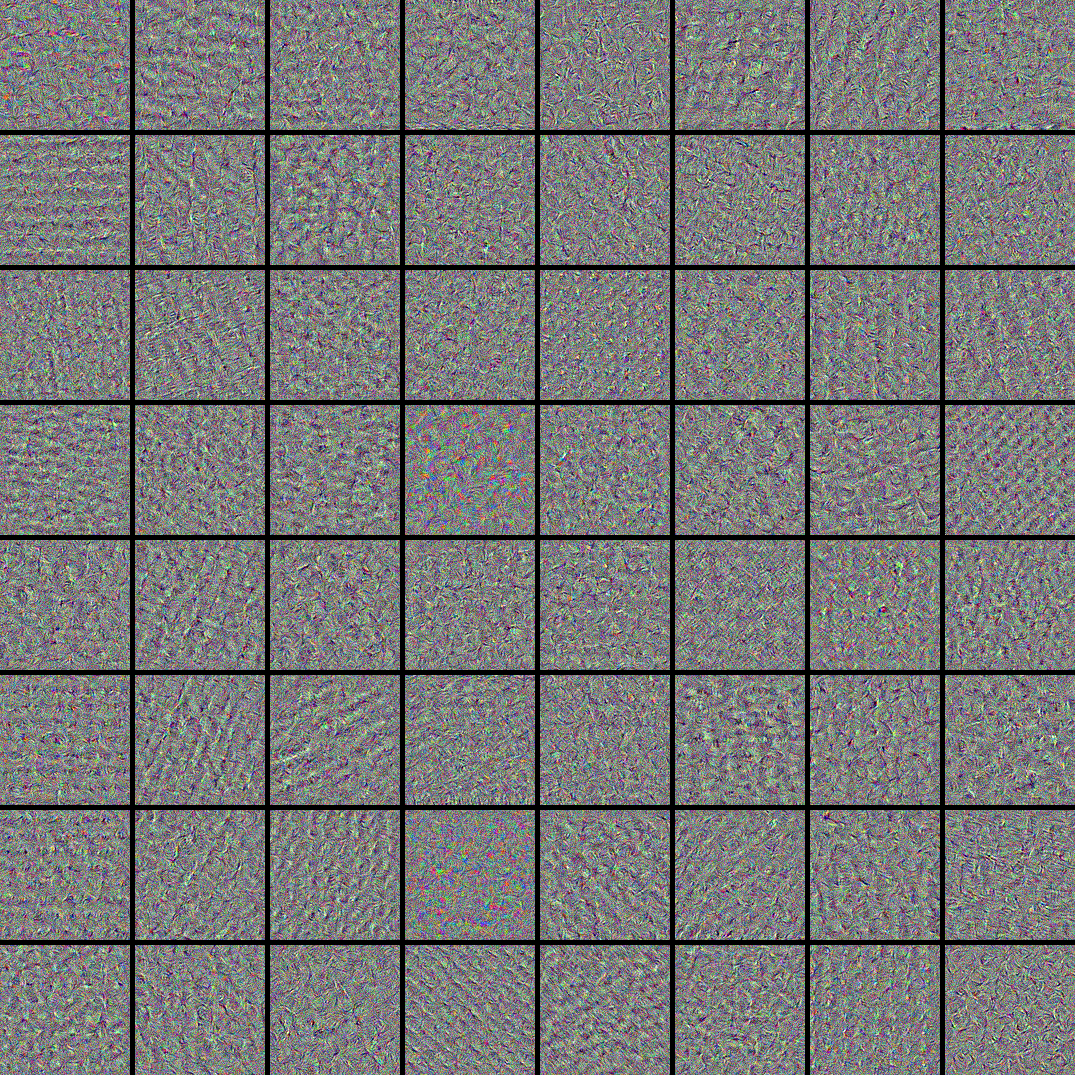

In [ ]:
# Fill the picture with our saved filters
for i in range(n):
  for j in range(n):
    img = all_imgs[i * n + j]
    stitched_filters[
                     (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
                     (cropped_height + margin) * j : (cropped_height + margin) * j
                     + cropped_height,
                     :,
    ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
# The local path to our target image
img_path = 'creative_commons_elephant.jpg'
# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))
# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03598930', 'jigsaw_puzzle', 0.24767092), ('n02012849', 'crane', 0.025773061), ('n03223299', 'doormat', 0.023818789)]


In [ ]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


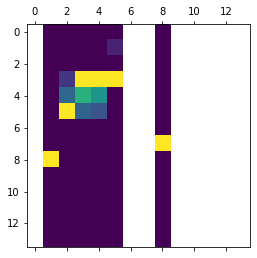

In [ ]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap, 0) 
plt.matshow(heatmap)

In [ ]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant2_2.jpg', superimposed_img)

True